In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import gc
from tqdm import tqdm
from scipy.sparse import csr_matrix
from  datetime import datetime, timedelta

In [2]:
cd C:\Users\minih\python_prac1\m5\git-repository\kaggle-m5-accuracy-library\library

C:\Users\minih\python_prac1\m5\git-repository\kaggle-m5-accuracy-library\library


In [3]:
from patair import reduce_mem_usage

In [4]:
cd C:\Users\minih\python_prac1\library\m5

C:\Users\minih\python_prac1\library\m5


In [5]:
def encode_categorical(df, cols):
    
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        #not_null = df[col][df[col].notnull()]
        df[col] = df[col].fillna('nan')
        df[col] = pd.Series(le.fit_transform(df[col]), index=df.index)

    return df


#calendar = encode_categorical(
 #   calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
#).pipe(reduce_mem_usage)

In [6]:
product = pd.read_pickle("product.pickle").pipe(reduce_mem_usage)

Mem. usage decreased to  0.64 Mb (0.0% reduction)


In [7]:
product

,id,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0
...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,1432,2,0,9,2
30486,FOODS_3_824_WI_3_validation,1433,2,0,9,2
30487,FOODS_3_825_WI_3_validation,1434,2,0,9,2
30488,FOODS_3_826_WI_3_validation,1435,2,0,9,2


In [8]:
#datas = pd.DataFrame()
#for i, file in enumerate(["dataCA_1.pickle", "dataCA_2.pickle", "dataCA_3.pickle", 
#            "dataCA_4.pickle", "dataTX_1.pickle", "dataTX_2.pickle", 
#           "dataTX_3.pickle", "dataWI_1.pickle", "dataWI_2.pickle", "dataWI_3.pickle"]):
#    data = pd.read_pickle(file).pipe(reduce_mem_usage)
#    data = encode_categorical(
#        data, ["item_id", "dept_id", "cat_id", "event_name_1", "event_name_2"],
#    ).pipe(reduce_mem_usage)
#    if(file[4:6] == "CA"):
#        data["state_id"] = 0
#        data = pd.merge(product[(product["state_id"] == 0) & (product["store_id"] == i)],data,how="left")
#    elif(file[4:6] == "TX"):
#        data["state_id"] = 1
#        data = pd.merge(product[(product["state_id"] == 1) & (product["store_id"] == i)],data,how="left")
#    else:
#        data["state_id"] = 2
#        data = pd.merge(product[(product["state_id"] == 2) & (product["store_id"] == i)],data,how="left")
#    data["store_id"] = i
#    datas = pd.concat([datas,data])

In [7]:
datas = pd.read_pickle("all_sales_train_validation_translated_contain_null.pickle")

In [8]:
datas = datas[datas["state_id"] == 1]

In [9]:
datas.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'sell_num', 'date', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price',
       'prev_28', 'p_prev_1', 'rolling_mean_t7', 'rolling_mean_t14',
       'rolling_std_t7', 'rolling_std_t14', 'price_change_t1',
       'rolling_price_std_t7', 'rolling_price_std_t30', 'year', 'quarter',
       'month', 'week', 'day', 'dayofweek', 'is_weekend'],
      dtype='object')

In [9]:
check_feature=[
               'prev_28', 'p_prev_1','rolling_mean_t7', 
               'rolling_mean_t14', 'price_change_t1','rolling_std_t7', 'rolling_std_t14',
               'rolling_price_std_t7', 'rolling_price_std_t30', 'price_change_t1', 'rolling_price_std_t7',
               ]

In [10]:
#dataの時系列特徴列(prev_〇など)をみてnanを含むデータ削除する
#len(np.unique(datas.dropna(subset=check_feature)["id"]))
datas.dropna(subset=check_feature, inplace=True)
#len(np.unique(datas.dropna(subset=check_feature)["id"]))

In [ ]:
#57日前のものとかは既に使え無さそう...

In [11]:
#x_train = datas[datas['date'] < '2016-04-18']
x_train = datas[datas['date'] < '2016-03-28']
y_train = x_train['sell_num']
#x_val = datas[datas['date'] >= '2016-04-18']
x_val = datas[(datas['date'] >= '2016-03-28')& (datas['date'] <= '2016-04-24')]
y_val = x_val['sell_num']
test = datas[datas['date'] > '2016-04-24']
del datas
gc.collect()

20

In [13]:
x_train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'sell_num', 'date', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price',
       'prev_28', 'p_prev_1', 'rolling_mean_t7', 'rolling_mean_t14',
       'rolling_std_t7', 'rolling_std_t14', 'price_change_t1',
       'rolling_price_std_t7', 'rolling_price_std_t30', 'year', 'quarter',
       'month', 'week', 'day', 'dayofweek', 'is_weekend'],
      dtype='object')

In [12]:
features = [
   #訓練に用いる特徴量をここに記述
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    #"state_id",
    "event_name_1",
    #"event_type_1",
    "event_name_2",
    #"event_type_2",
    
    
    #"snap_CA",
    "snap_TX",
    #"snap_WI",
    
    "sell_price",
    # demand features.
    #'prev_14', 
    'prev_28',
    #'prev_182', 
    #'prev_365', 
    'p_prev_1', 
    'rolling_mean_t7',
    'rolling_mean_t14', 
    'rolling_mean_t30',
    'rolling_std_t7',
    'rolling_std_t14',
    'rolling_std_t30',
    #'rolling_mean_t60', 
    #'rolling_mean_t90',
    #'rolling_mean_t180',  
    # price features
    "price_change_t1",
    #"price_change_t365",
    #'rolling_price_max_t365', 
    #'price_change_t365',
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    #"is_year_end",
    #"is_year_start",
    #"is_quarter_end",
    #"is_quarter_start",
    #"is_month_end",
    #"is_month_start",
    #"is_weekend",
]

train_set = lgb.Dataset(x_train[features], y_train)
val_set = lgb.Dataset(x_val[features], y_val)

del x_train, y_train

In [14]:
len(y_val)

341488

In [13]:
#kernelから取ってきたパラメータ
params = {
        "objective" : "poisson",
        #"metric" :["custom", "rmse"],
        "metric" : "rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "nthread" : 2,
        'verbosity': 1,
        'num_iterations' : 1200,
        'num_leaves': 128,
        "min_data_in_leaf": 100,
        "random_state": 32,
}

In [15]:
params ={
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric':["custom", "rmse"],
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**11-1,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1400,
            'boost_from_average': False,
            'verbose': -1,
         } 

In [16]:
#訓練
model = lgb.train(params, train_set, early_stopping_rounds = 50,
        valid_sets = [train_set, val_set], categorical_feature = ["item_id","dept_id","cat_id","store_id","event_name_1","event_name_2"], verbose_eval = 20)
#valid_sets = [train_set, val_set], categorical_feature = ["item_id","dept_id","cat_id","store_id","state_id","event_name_1","event_name_2"], verbose_eval = 50, feval= wrmsse)
#カテゴリ変数は、エンコードしたかに関わらず明示しておいた方が良さそう

C:\Users\minih\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 2.95097	valid_1's rmse: 2.62941
[40]	training's rmse: 2.52473	valid_1's rmse: 2.16425
[60]	training's rmse: 2.33718	valid_1's rmse: 1.97164
[80]	training's rmse: 2.24693	valid_1's rmse: 1.90631
[100]	training's rmse: 2.19991	valid_1's rmse: 1.88186
[120]	training's rmse: 2.1676	valid_1's rmse: 1.87222
[140]	training's rmse: 2.14165	valid_1's rmse: 1.86886
[160]	training's rmse: 2.1185	valid_1's rmse: 1.86702
[180]	training's rmse: 2.10298	valid_1's rmse: 1.86561
[200]	training's rmse: 2.09088	valid_1's rmse: 1.86482
[220]	training's rmse: 2.08064	valid_1's rmse: 1.86511
[240]	training's rmse: 2.07142	valid_1's rmse: 1.8651
[260]	training's rmse: 2.06449	valid_1's rmse: 1.86401
[280]	training's rmse: 2.05665	valid_1's rmse: 1.86345
[300]	training's rmse: 2.0509	valid_1's rmse: 1.86287
[320]	training's rmse: 2.04542	valid_1's rmse: 1.86188
[340]	training's rmse: 2.03921	valid_1's rmse: 1.8616
[360]	trainin

In [17]:
#訓練
model = lgb.train(params, train_set, early_stopping_rounds = 50,
        valid_sets = [train_set, val_set], categorical_feature = ["item_id","dept_id","cat_id","store_id","event_name_1","event_name_2"], verbose_eval = 20)
#valid_sets = [train_set, val_set], categorical_feature = ["item_id","dept_id","cat_id","store_id","state_id","event_name_1","event_name_2"], verbose_eval = 50, feval= wrmsse)
#カテゴリ変数は、エンコードしたかに関わらず明示しておいた方が良さそう

C:\Users\minih\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\minih\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'item_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 2.43693	valid_1's rmse: 2.23073
[40]	training's rmse: 2.16584	valid_1's rmse: 1.99369
[60]	training's rmse: 2.09537	valid_1's rmse: 1.94415
[80]	training's rmse: 2.06994	valid_1's rmse: 1.93834
[100]	training's rmse: 2.05159	valid_1's rmse: 1.9381
[120]	training's rmse: 2.03781	valid_1's rmse: 1.93637
[140]	training's rmse: 2.02145	valid_1's rmse: 1.92515
[160]	training's rmse: 2.00839	valid_1's rmse: 1.92004
[180]	training's rmse: 1.99899	valid_1's rmse: 1.91831
[200]	training's rmse: 1.99004	valid_1's rmse: 1.91571
[220]	training's rmse: 1.98284	valid_1's rmse: 1.91406
[240]	training's rmse: 1.97562	valid_1's rmse: 1.91298
[260]	training's rmse: 1.96834	valid_1's rmse: 1.90942
[280]	training's rmse: 1.96195	valid_1's rmse: 1.90899
[300]	training's rmse: 1.95288	valid_1's rmse: 1.9072
[320]	training's rmse: 1.94549	valid_1's rmse: 1.90569
[340]	training's rmse: 1.93789	valid_1's rmse: 1.90514
[360]	trai

In [17]:
#いちおうR値でも精度を検証
#予測
val_pred = model.predict(x_val[features])

In [19]:
#R値
r2_score(val_pred,y_val)

0.5988016015334101

In [18]:
r2_score(val_pred,y_val)

0.5904891304166953

No handles with labels found to put in legend.


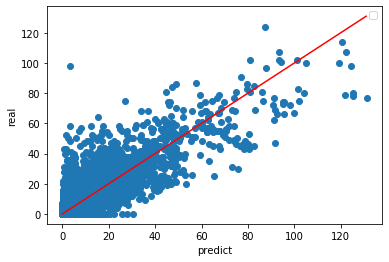

In [20]:
#R値グラフの表示
max_val = np.max(val_pred)
if max_val < np.max(y_val):
    max_val = np.max(y_val)

plt.scatter(val_pred,y_val)
plt.plot(np.arange(0,max_val),np.arange(0,max_val),color='red')
plt.xlabel("predict")
plt.ylabel("real")
plt.legend()

In [19]:
import pickle

In [20]:
with open('lgb_TX.pickle', mode='wb') as fp:
         pickle.dump(model, fp)

In [21]:
test = test[test["date"] <= "2016-05-22"]

In [24]:
len(test)

256116

In [22]:
#テストデータを用いて予測
y_pred = model.predict(test[features])
test['demand'] = y_pred

In [23]:
result = pd.DataFrame(val_pred,columns=["valid"])
result["predict"] = y_pred

In [24]:
result.to_csv("result_lgb_TX.csv")

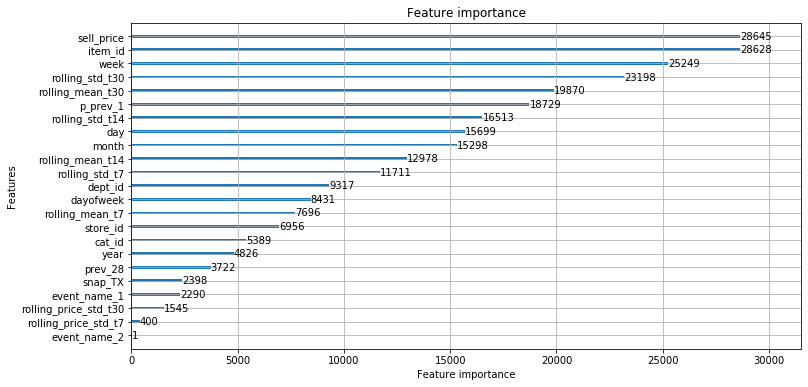

In [26]:
lgb.plot_importance(model, figsize=(12, 6))

In [25]:
#提出用ファイルを読み込む
submission = pd.read_csv('sample_submission.csv')

In [33]:
test["date"]

558       2016-04-25
559       2016-04-26
560       2016-04-27
561       2016-04-28
562       2016-04-29
             ...    
2668524   2016-05-18
2668525   2016-05-19
2668526   2016-05-20
2668527   2016-05-21
2668528   2016-05-22
Name: date, Length: 853720, dtype: datetime64[ns]

In [42]:
#予測値を提出用ファイルに整形
predictions = test[['id', 'date', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])

In [43]:
#finalが提出形式のdfなので、これをto_csvする
final.to_csv('create3.csv', index = False)